In [333]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard, LKV
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt

### Load model

In [334]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [335]:
t_span = (0, 10)
N = 150
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [336]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [337]:
x0, y0 = 1.59, 0.95

epsilon = 0.5
xi0 = (x0 - 1) / epsilon
eta0 = (y0 - 1) / epsilon

In [338]:
xi0, eta0

(1.1800000000000002, -0.10000000000000009)

In [339]:
alpha_list = [0.2]
ic_list = [[xi0, eta0]]
epsilon_list = [epsilon]
p_list = [5]

In [340]:
xi0, eta0

(1.1800000000000002, -0.10000000000000009)

## Lindstedt-Poincare method

In [341]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution_LKV(epsilon_list, p_list, ic_list, alpha_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

In [342]:
w_sol

[[np.float64(0.4472135954999579),
  np.float64(-0.0003023906987823545),
  np.float64(-0.053669477871356126),
  np.float64(0.06341571091177457),
  np.float64(-0.058060439814278886),
  np.float64(0.04074298108370102)]]

In [343]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-10, check_divergence=False))

w_final_list

[[np.float64(0.4472135954999579),
  np.float64(0.44706240015056675),
  np.float64(0.4336450306827277),
  np.float64(0.44157199454669954),
  np.float64(0.43794321705830713),
  np.float64(0.4392164352171728)]]

In [344]:
#_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
#w_teor

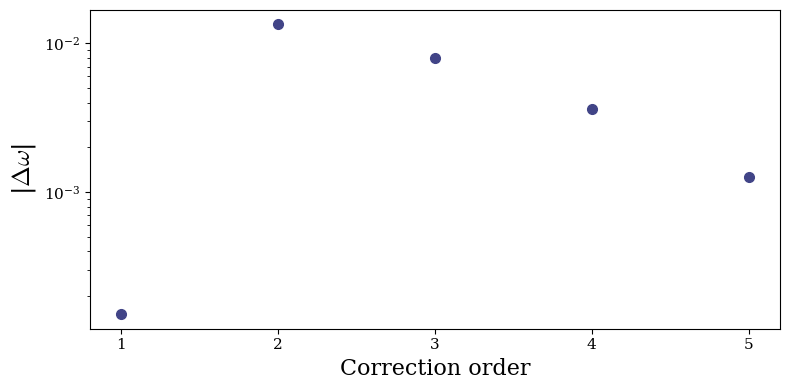

In [345]:
LPM.relative_error(w_final_list[0])
#LPM.w_absolute_error(w_final_list[0], w_teor)

In [346]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

In [347]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_lv_comparison(t_eval_lpm, t_eval_num, NN_TL_solution_LPM, x, y, epsilon_list):
    # --- Style settings ---
    label_fs  = 18
    tick_fs   = 14
    legend_fs = 14
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(12, 4.8))

    # --- Define consistent colors for (xi,x) and (eta,y) ---
    color_xi  = cm.viridis(0.15)  # i = 0
    color_eta = cm.viridis(0.55)  # i = 1

    # --- Numerical reference first (lighter colors) ---
    ax.plot(
        t_eval_num,
        x,
        label="$x$",
        color=color_xi,
        linewidth=2.0,
        alpha=0.7,
        zorder=1,
    )

    ax.plot(
        t_eval_num,
        y,
        label="$y$",
        color=color_eta,
        linewidth=2.0,
        alpha=0.7,
        zorder=1,
    )

    # --- PTL-PINN approximations last (bolder dashed lines) ---
    ax.plot(
        t_eval_lpm,
        1 + epsilon_list[0] * NN_TL_solution_LPM[:, 0],
        label=r"$1 + \varepsilon \xi$",
        color=color_xi,
        linewidth=2.4,
        linestyle=(0, (6, 3)),  # longer dashes
        marker="o",
        markersize=4.5,
        markevery=100,
        alpha=0.95,
        zorder=3,
    )

    ax.plot(
        t_eval_lpm,
        1 + epsilon_list[0] * NN_TL_solution_LPM[:, 1],
        label=r"$1 + \varepsilon \eta$",
        color=color_eta,
        linewidth=2.4,
        linestyle=(0, (6, 3)),  
        marker="s",
        markersize=4.5,
        markevery=100,
        alpha=0.95,
        zorder=3,
    )

    # --- Axis labels and ticks ---
    ax.set_xlabel("t", fontsize=label_fs, labelpad=6)
    ax.set_ylabel("Solution", fontsize=label_fs, labelpad=8)
    ax.tick_params(axis="both", labelsize=tick_fs)

    # --- Legend on top ---
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
        fontsize=legend_fs,
        frameon=False,
        handlelength=2.8,
        markerscale=1.2,
        labelspacing=0.4,
    )

    plt.tight_layout()
    plt.show()



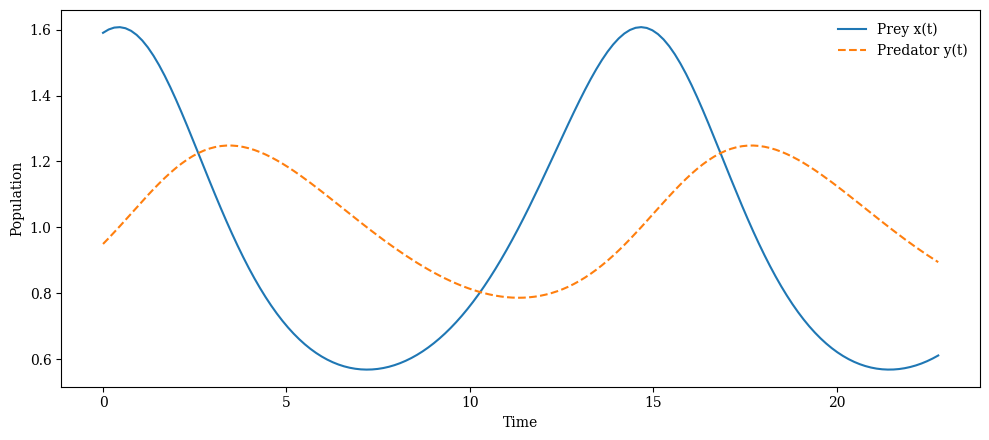

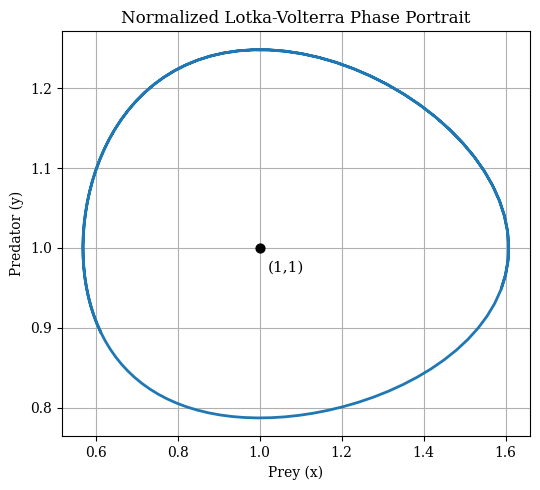

In [348]:
ode = equations.lv_normalized(alpha_list[0])
sol = numerical.solve_ode_equation(ode, (t_eval_lpm[0], t_eval_lpm[-1]), t_eval_lpm, [x0, y0])
x, y = sol

LKV.plot_numerical_LKV(x, y, t_eval_lpm)

/tmp/ipykernel_149412/3708410380.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


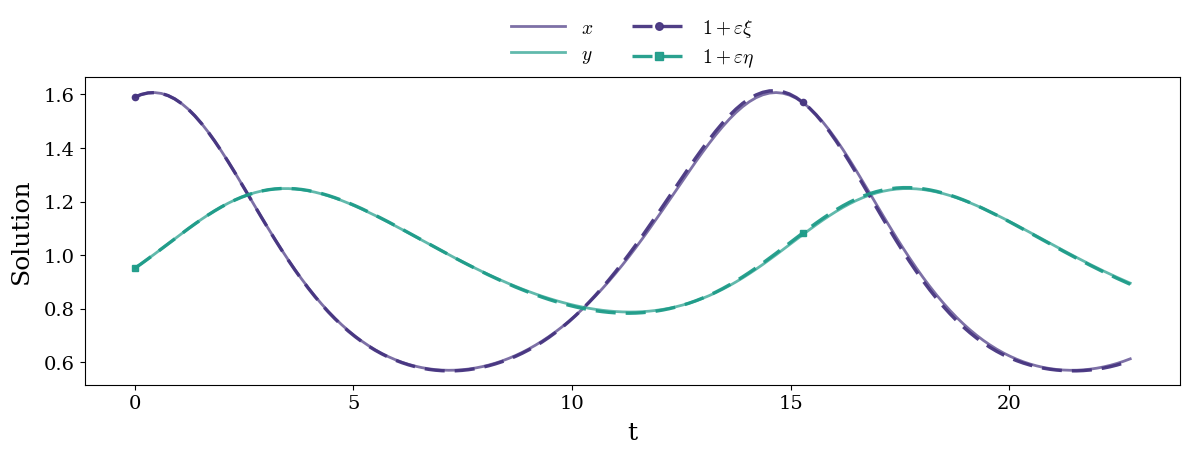

In [349]:
plot_lv_comparison(t_eval_lpm, t_eval_lpm, NN_TL_solution_LPM, x, y, epsilon_list)

In [350]:
np.mean(np.abs(y - 1 - epsilon * NN_TL_solution_LPM[:, 1]))

np.float64(0.002451525327472212)

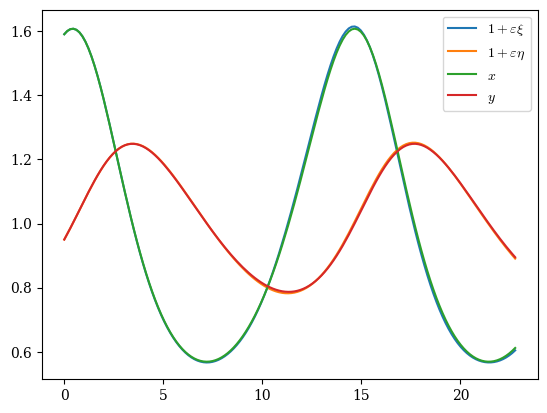

In [351]:
plt.plot(t_eval_lpm, 1 + epsilon_list[0] * NN_TL_solution_LPM[:, 0], label=r"$1 + \varepsilon \xi$")
plt.plot(t_eval_lpm, 1 + epsilon_list[0] * NN_TL_solution_LPM[:, 1], label=r"$1 + \varepsilon \eta$")
plt.plot(t_eval_lpm, x, label="$x$")
plt.plot(t_eval_lpm, y, label="$y$")
plt.legend()

In [352]:
perturbation_solution_LPM[0].shape

(150, 2)

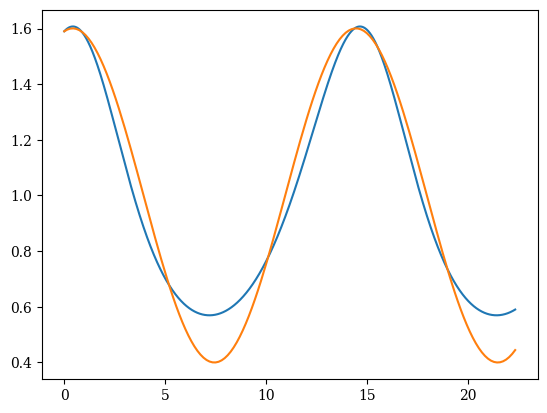

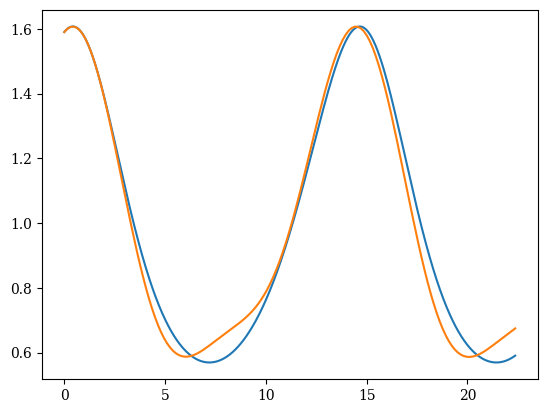

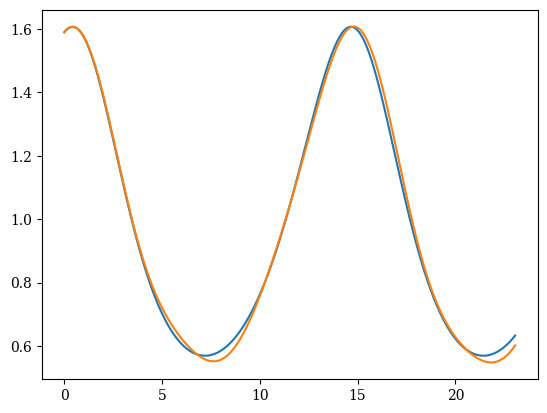

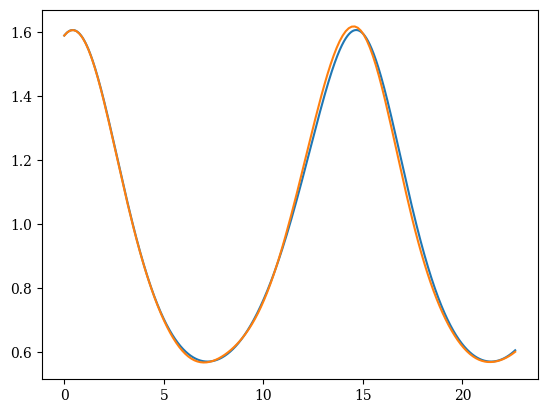

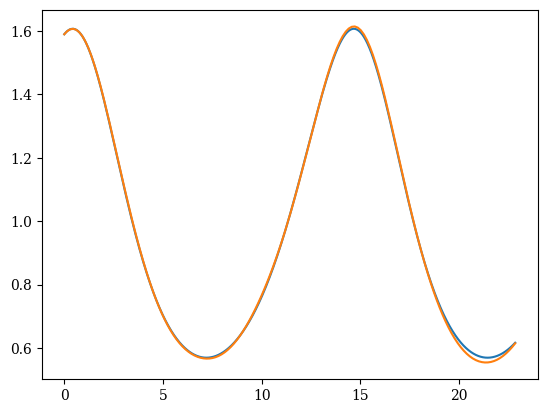

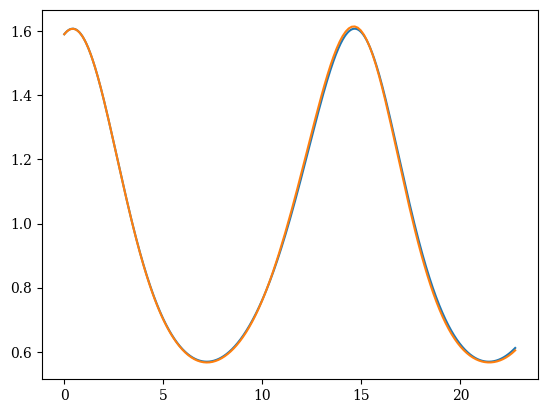

In [353]:
w_final = []
xi_final = []
error = []

for i in range(len(w_sol[0])):

    if i == 0:
        w_loop = np.sqrt(alpha_list[0])
        xi_loop = perturbation_solution_LPM[0][:, 0]
    else:
        w_loop = w_final[i - 1] + (epsilon ** i)  * w_sol[0][i]
        xi_loop  = xi_final[i - 1] + (epsilon ** i) * perturbation_solution_LPM[i][:, 0]

    w_final.append(w_loop)
    xi_final.append(xi_loop)

    t_span_loop = (0, t_span[-1]/w_loop)
    t_eval_loop_ptl = np.linspace(t_span_loop[0], t_span_loop[1], N)
    dt = (t_eval_loop_ptl[1] - t_eval_loop_ptl[0])/200
    t_eval_loop = np.linspace(t_span_loop[0], t_span_loop[1], (t_eval_loop_ptl.size - 1)*200 + 1)
    sol_loop = numerical.solve_ode_equation(ode, t_span_loop, t_eval_loop, [x0, y0])
    x_loop, y_loop = sol_loop 

    error.append(np.mean(np.abs(1 + epsilon * xi_loop - x_loop[::200])))

    plt.plot(t_eval_loop, x_loop)
    plt.plot(t_eval_loop_ptl, 1 + epsilon * xi_loop)
    plt.show()

In [354]:
error

[np.float64(0.07949449774984446),
 np.float64(0.0409492510808324),
 np.float64(0.01431635419440733),
 np.float64(0.010738388739687747),
 np.float64(0.004383007424774669),
 np.float64(0.005336019723033311)]

In [355]:
scale = int(10000 / N)
scale

66

In [356]:
dt = (t_eval[1] - t_eval[0])/scale
t_eval_high_acc = np.linspace(t_span[0], t_span[1], (t_eval.size - 1)*scale + 1)
num_high_acc = numerical.solve_ode_equation(ode, (t_eval_high_acc[0], t_eval_high_acc[-1]), t_eval_high_acc, ic_list[0])[0, :]
numerical_undamped_duffing = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

num_low_acc = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0], rtol=1e-3, atol=1e-3, method="Radau")[0, :]
print(np.mean(np.abs(num_low_acc - num_high_acc[::scale])))

num_low_acc = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0], rtol=1e-3, atol=1e-3, method="RK45")[0, :]
print(np.mean(np.abs(num_low_acc - num_high_acc[::scale])))

0.002466601114289589
0.0024856439798471176


```
N = 50:

[np.float64(0.07677099973791363),
 np.float64(0.046592397705639804),
 np.float64(0.013575284186061333),
 np.float64(0.016728185398972372),
 np.float64(0.00851093986309823),
 np.float64(0.011305434177548907)]

N = 100:

[np.float64(0.07917858715250384),
 np.float64(0.041119086442758995),
 np.float64(0.01413197772151808),
 np.float64(0.01078762948268094),
 np.float64(0.004149477433684641),
 np.float64(0.005368907385856304)]

N = 200:

[np.float64(0.07948845795227003),
 np.float64(0.040916509859998625),
 np.float64(0.014341397477552077),
 np.float64(0.010713820990453635),
 np.float64(0.0043070689460686035),
 np.float64(0.005303447351417099)]

N = 400:

[np.float64(0.07952099078297582),
 np.float64(0.04093916506308438),
 np.float64(0.01431519457004806),
 np.float64(0.010767325018700558),
 np.float64(0.004348772131848744),
 np.float64(0.005339104182990371)]

N = 500:

[np.float64(0.07952218224811511),
 np.float64(0.04092652725211647),
 np.float64(0.014318850936768232),
 np.float64(0.010761350690118413),
 np.float64(0.004336368275511229),
 np.float64(0.005330641704641659)]

[np.float64(0.011305434177548907), np.float64(0.005368907385856304), np.float64(0.005303447351417099), np.float64(0.005339104182990371), np.float64(0.005330641704641659)]
```

```

```

```